**DATA CLEANER**

**Generating a pandas dataframe from the source .csv file**

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set options to show all columns
pd.set_option('display.max_columns', None)

# Load csv file and generate pandas dataframe
data_scrape_csv = r'..\data\raw\immo_scraper_merged_with_landsurface.csv' # Fill your path to file
data_scraped = pd.read_csv(data_scrape_csv, sep = ',')
data_scraped_shape = data_scraped.shape

**Cosmetic clean and preprocessing:**
- cosmetic changes (e.g. no blank spaces)
- text fields as strings, and in title case
- no wrongly encoded values (e.g. a text value in the price column, numeric values as integer or float)
- removal of record with dutch postcode

In [114]:
# Copy dataframe contents to a new dataframe
data_clean_1 = data_scraped.copy()

# Edit text in the columns
text_edit_columns = ['Subtype', 'Type_of_sale', 'Kitchen_type', 'State_of_building' ]

for column in text_edit_columns:
    data_clean_1[column] = data_clean_1[column].astype(str)  # Ensure the column is treated as string
    data_clean_1[column] = data_clean_1[column].str.replace('_', ' ').str.capitalize() #Replace "_" to space, editing text (first capital letter, rest lower case)

#Edit text of cities and street names
names_edit_columns = ['locality_name', 'street']

for column in names_edit_columns:
    data_clean_1[column] = data_clean_1[column].astype(str)  # Ensure the column is treated as string
    data_clean_1[column] = data_clean_1[column].str.title() # Editing text (first capital letters, rest lower case)

# Remove zip code from brackets, e.g. "Tielt (8700)" -> "Tielt"
data_clean_1['locality_name'] = data_clean_1['locality_name'].str.replace(r"\s*\(\d+\)", "", regex=True)

# Edit the numbers in columns

# Selecting the columns to change
number_edit_columns = ['Number_of_bedrooms', 'Living_area', 'landSurface', 'Number_of_facades', 'Price', 'terraceSurface', 'gardenSurface']

# Converting the cell value to int (so that they are integers).
for column in number_edit_columns:
    data_clean_1[column] = pd.to_numeric(data_clean_1[column], errors='coerce').astype('Int64')

# Values conversion cells from false to 0, true to 1.
columns_for_change_01 = ['Open_fire', 'Swimming_Pool', 'Furnished'] # Columns for change, leave , 'hasTerrace' for now (not well maintained inimmoweb)
data_clean_1[columns_for_change_01] = data_clean_1[columns_for_change_01].replace({False:0, True:1}).fillna(0).astype('Int64')

# Converting the postal codes to dtype 'str'
data_clean_1['Postal_code'] = data_clean_1['Postal_code'].astype(str)

# Dropping a dutch postal code
data_clean_1 = data_clean_1[data_clean_1['Postal_code'] != '4524 JM']

# Display info on dataframe
data_clean_1_shape = data_clean_1.shape
data_clean_1.shape


C:\Users\tom_v\AppData\Local\Temp\ipykernel_3672\2494517835.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clean_1[columns_for_change_01] = data_clean_1[columns_for_change_01].replace({False:0, True:1}).fillna(0).astype('Int64')


(9994, 27)

**Removal of duplicates:**

In [115]:
# Copy dataframe contents to a new dataframe, via removal of duplicates
data_clean_2 = data_clean_1.drop_duplicates(subset=['latitude', 'longitude', 'street', 'number', 'Subtype'])
duplicates = data_clean_1[data_clean_1.duplicated(subset=['latitude', 'longitude', 'street', 'number', 'Subtype'])]

data_clean_2_shape = data_clean_2.shape
data_clean_2.shape

(9089, 27)

**Removal of records - based on property subtypes:**
- removed records with starting price (indicates house groups or public sales)
- removed subtypes house group, castle, exceptional properties, 'other' properties --> these property types 'House group', 'Castle', 'Other property', 'Exceptional property' are not used in our analysis of housing and apartment prices because they represent categories that are either undefined ('other property'), not comparable ('house group'), or exceptional ('castle','expceptional property').
- removed chalet and bungalow, as they reflect a different segment, such as trailers on a camping, tiny houses, but also villa style properties in bad shape.

Our analysis focuses on more typical housing types to ensure relevance and consistency in the data. See also later for further focusing on the subtype 'House'.

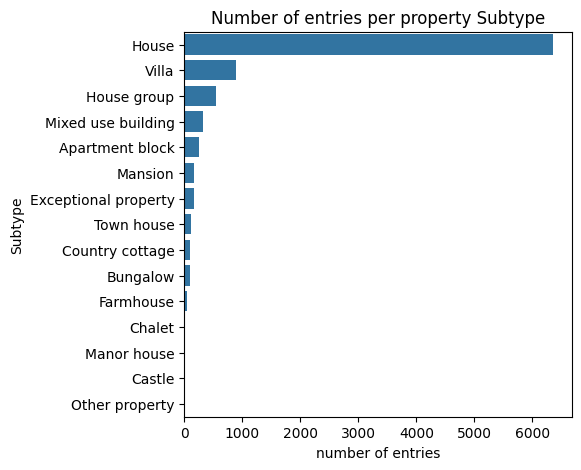

In [116]:
# Making plot for the presentation: subtypes in the original dataset
df = data_clean_2
col= 'Price'
grp = 'Subtype'

# Step 1: Calculate the median for the category Price, grouped per subtype
#medians = df.groupby(grp)[col].median().reset_index()
frequency = df[grp].value_counts()

# Step 2: Sort the categories based on the median value of 'Value'
#category_order = medians.groupby(grp)[col].median().sort_values(ascending=False).index

# Step 3: create map

sns.color_palette("colorblind")
#sns.boxplot(data=df, y=col, hue=grp, hue_order=category_order, orient="v",legend=False).set_title(col)
plt.figure(figsize=(5, 5))
sns.barplot(x=frequency.values, y=frequency.index, orient="h")
plt.title(f'Number of entries per property {grp}')
plt.xlabel('number of entries')
#plt.ylabel(grp)
plt.show()

# Move the legend to the right side
#plt.legend(loc='upper center')

#plt.tight_layout()
plt.show()

In [117]:
# Copy dataframe contents to a new dataframe
data_clean_3 = data_clean_2.copy()

# Remove lines where 'Starting_price' is True
count_has_starting_price = (data_clean_3['Starting_price'] == True).sum()
data_clean_3 = data_clean_3[data_clean_3['Starting_price'] != True]

# Cleaning data from subtypes that are not our focus:
subtypes_to_remove = ['House group', 'Chalet', 'Bungalow', 'Castle', 'Other property', 'Exceptional property']
count_subtypes_removed = (data_clean_3['Subtype'].isin(subtypes_to_remove)).sum()
data_clean_3 = data_clean_3[~data_clean_3['Subtype'].isin(subtypes_to_remove)]

# Display info on the dataframe
data_clean_3_shape = data_clean_3.shape

# Checks how many properties per subtype
data_clean_3['Subtype'].value_counts()
data_clean_3.shape
data_clean_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7587 entries, 0 to 9994
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7587 non-null   int64  
 1   locality_name       7587 non-null   object 
 2   Postal_code         7587 non-null   object 
 3   Price               7573 non-null   Int64  
 4   Subtype             7587 non-null   object 
 5   Number_of_rooms     2924 non-null   float64
 6   Number_of_bedrooms  7587 non-null   Int64  
 7   Living_area         7425 non-null   Int64  
 8   sale_annuity        14 non-null     object 
 9   Type_of_sale        7587 non-null   object 
 10  street              7587 non-null   object 
 11  number              7561 non-null   object 
 12  latitude            7578 non-null   float64
 13  longitude           7578 non-null   float64
 14  Open_fire           7587 non-null   Int64  
 15  Swimming_Pool       7587 non-null   Int64  
 16  hasTerrace 

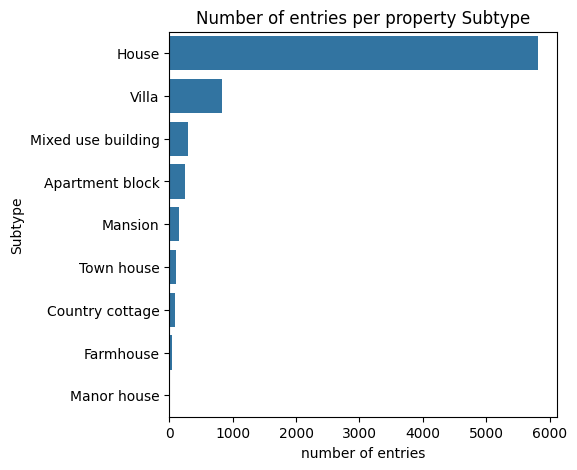

In [118]:
# Making plot for the presentation: subtypes in the original dataset
df = data_clean_3
col= 'Price'
grp = 'Subtype'

# Step 1: Calculate the median for the category Price, grouped per subtype
#medians = df.groupby(grp)[col].median().reset_index()
frequency = df[grp].value_counts()

# Step 2: Sort the categories based on the median value of 'Value'
#category_order = medians.groupby(grp)[col].median().sort_values(ascending=False).index

# Step 3: create map

sns.color_palette("colorblind")
#sns.boxplot(data=df, y=col, hue=grp, hue_order=category_order, orient="v",legend=False).set_title(col)
plt.figure(figsize=(5, 5))
sns.barplot(x=frequency.values, y=frequency.index, orient="h")
plt.title(f'Number of entries per property {grp}')
plt.xlabel('number of entries')
#plt.ylabel(grp)
plt.show()

# Move the legend to the right side
#plt.legend(loc='upper center')

#plt.tight_layout()
plt.show()

**Dealing with missing values: assumptions and operations on the dataset**
- Numerical data: 'Living area', 'landSurface'
- Binary data: 'Open_fire', 'Swimming_pool', 'Furnished', 'hasTerrace': if missing values for --> set to 0
- Categorical data: 'hasGarden', 'epc', 'Kitchen_type', 'State_of_building': missing values --> set to 0

In [119]:
# Overview and grouping of the datacolumns for loop later on
numerical_columns = ['Price','landSurface','Living_area','Number_of_facades','Number_of_bedrooms','gardenSurface', 'terraceSurface']
#gardenSurface', 'terraceSurface' are not reliably maintained, just change <NA> to NaN to avoid errors 

categorical_columns = ['Kitchen_type','State_of_building','epc'] # 'Subtype' will be approached differently (see below)
binary_columns = ['Swimming_Pool','Open_fire','Furnished'] # 'hasGarden', 'hasTerrace', are not reliably maintained, leave as is so far

In [120]:
# Copy dataframe contents to a new dataframe
data_clean_4 = data_clean_3.copy()

# Dealing with missing values 
# # Numerical columns: if NaN or 0, assigning the value to the median of the column (Imputation)
for col in numerical_columns:
    # Calculate the median excluding NaN and 0 values
    col_median = data_clean_4[col][data_clean_4[col] != 0].dropna().median()
    # Replace 0 values with the median and fill NaN values
    data_clean_4[col] = data_clean_4[col].replace(0, col_median).fillna(col_median)

# # Binary columns: if NaN or 0, assigning the value to 0
for col in binary_columns:
    # Replace Nan fill NaN values with 0
    data_clean_4[col] = data_clean_4[col].replace('Nan', 0).fillna(0)

#df['Kitchen_type'] = df['Kitchen_type'].replace({0: np.nan, 'Nan': np.nan})

# # Categorical columns: if NaN or 0, assigning the value to 0
for col in categorical_columns:
    data_clean_4[col] = data_clean_4[col].replace({0: np.nan, 'Nan': np.nan})
    col_mode = data_clean_4[col][data_clean_4[col] != 0].dropna().mode()[0]
    data_clean_4[col] = data_clean_4[col].fillna(col_mode)

data_clean_4_shape = data_clean_4.shape
data_clean_4.head(10)

,id,locality_name,Postal_code,Price,Subtype,Number_of_rooms,Number_of_bedrooms,Living_area,sale_annuity,Type_of_sale,street,number,latitude,longitude,Open_fire,Swimming_Pool,hasTerrace,terraceSurface,hasGarden,gardenSurface,Kitchen_type,Number_of_facades,State_of_building,Furnished,Starting_price,epc,landSurface
0,20252354,Ronse,9600,319000,House,NaN,3,125,NaN,For sale,Rotterij,148,50.744176,3.625722,0,0,True,23,True,370,Installed,4,To renovate,0,NaN,F,767
1,20251003,Geraardsbergen,9500,299999,House,NaN,3,167,NaN,For sale,Pirrestraat,17,50.752121,3.925495,0,0,True,23,True,895,Installed,2,Good,0,NaN,D,1050
8,20252002,Mechelen,2800,275000,House,NaN,3,154,NaN,For sale,Caputsteenstraat,150,51.033269,4.491795,0,0,True,10,True,20,Semi equipped,2,To renovate,0,NaN,E,120
9,20252352,Gooik,1755,295000,House,NaN,3,172,NaN,For sale,Strijlandstraat,45,50.791877,4.084293,0,0,True,23,True,300,Installed,3,To renovate,0,NaN,F,309
18,20250577,Sint-Katelijne-Waver,2860,345000,Apartment block,NaN,1,43,NaN,For sale,Ijzerenveld,4,51.034950,4.511372,0,0,True,4,NaN,220,Installed,2,Good,0,NaN,B,70
19,20250989,Oetingen,1755,560000,Mixed use building,NaN,4,350,NaN,For sale,Blijkheerstraat,70,50.775412,4.047057,0,0,True,40,True,32,Installed,3,Good,0,NaN,C,412
20,20250985,Oetingen,1755,560000,House,NaN,4,350,NaN,For sale,Blijkheerstraat,70,50.775412,4.047057,0,0,True,40,True,32,Installed,3,Good,0,NaN,C,412
21,20251715,Dilbeek,1700,715000,House,19.0,3,280,NaN,For sale,Herdebeekstraat 94-94A,0,50.840610,4.228425,0,1,True,36,True,374,Installed,3,As new,0,False,C,374
22,20248858,Woluwe-Saint-Lambert,1200,790000,House,9.0,5,349,NaN,For sale,Rue De La Cambre - Terkamerenstraat,296,50.839333,4.430145,1,0,True,14,True,60,Usa hyper equipped,2,Good,0,False,F,160
23,20245694,Herzele,9550,198800,House,NaN,3,125,NaN,For sale,Stationsstraat,173,50.894568,3.884342,0,0,True,45,True,106,Semi equipped,2,To renovate,0,NaN,F,250


**Removing unnecessary columns**

In [121]:
# Removing unnecessary columns
columns_to_drop = ['Number_of_rooms', 'sale_annuity', 'Starting_price', 'Type_of_sale', 'hasGarden']
data_clean_5 = data_clean_4.drop(columns=columns_to_drop, errors='ignore')
data_clean_5_shape = data_clean_5.shape
data_clean_5.shape

(7587, 22)

**Adjusting datatypes**

In [122]:
# transform 'int64' to 'Int64' to handle NaN

int_columns = data_clean_5.select_dtypes(include=['int64'])

for col in int_columns.columns:
    data_clean_5[col] = data_clean_5[col].astype('Int64')

# transform dtypes 'object' to 'category'
int_columns = data_clean_5.select_dtypes(include=['object'])

for col in int_columns.columns:
    data_clean_5[col] = data_clean_5[col].astype('category')

data_clean_5['Postal_code'] = data_clean_5['Postal_code'].astype('category')

data_clean_5['Open_fire'] = data_clean_5['Open_fire'].astype('bool')
data_clean_5['Swimming_Pool'] = data_clean_5['Swimming_Pool'].astype('bool')
data_clean_5['hasTerrace'] = data_clean_5['hasTerrace'].astype('bool')
data_clean_5['Furnished'] = data_clean_5['Furnished'].astype('bool')

# Display info on the dataframe
data_clean_5_shape = data_clean_5.shape
data_clean_5.shape
data_clean_5.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7587 entries, 0 to 9994
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  7587 non-null   Int64   
 1   locality_name       7587 non-null   category
 2   Postal_code         7587 non-null   category
 3   Price               7587 non-null   Int64   
 4   Subtype             7587 non-null   category
 5   Number_of_bedrooms  7587 non-null   Int64   
 6   Living_area         7587 non-null   Int64   
 7   street              7587 non-null   category
 8   number              7561 non-null   category
 9   latitude            7578 non-null   float64 
 10  longitude           7578 non-null   float64 
 11  Open_fire           7587 non-null   bool    
 12  Swimming_Pool       7587 non-null   bool    
 13  hasTerrace          5110 non-null   object  
 14  terraceSurface      7587 non-null   Int64   
 15  gardenSurface       7587 non-null   Int64  

**Lumping together subtypes via mapping**

In [123]:
# Copy dataframe contents to a new dataframe
data_clean_6 = data_clean_5.copy()

# Showing each subtype and its count, before mapping
print(data_clean_6['Subtype'].value_counts())

# Lumping together subtypes via mapping
category_map = {'Mansion': 'Villa', 'Manor house': 'Villa', 'Country cottage':'Farmhouse','Town house':'House','Mixed use building':'Commercial','Apartment block':'Commercial'}
data_clean_6['Subtype'] = data_clean_6['Subtype'].map(category_map).fillna(data_clean_6['Subtype'])

# Showing each subtype and its count, after mapping
print(data_clean_6['Subtype'].value_counts())

# Display info on the dataframe
data_clean_6_shape = data_clean_6.shape

Subtype
House                 5821
Villa                  827
Mixed use building     300
Apartment block        241
Mansion                158
Town house             103
Country cottage         87
Farmhouse               40
Manor house             10
Name: count, dtype: int64
Subtype
House         5924
Villa          995
Commercial     541
Farmhouse      127
Name: count, dtype: int64


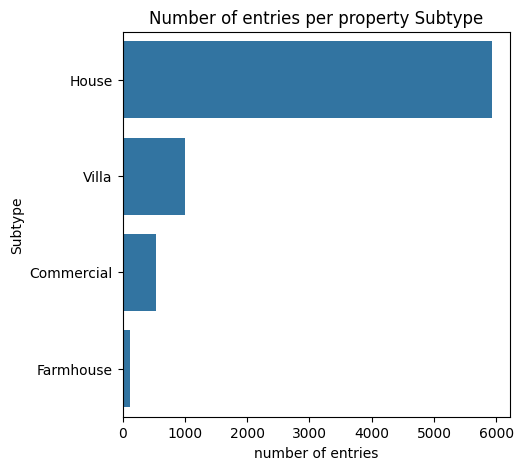

In [124]:
# Making plot for the presentation: subtypes in the original dataset
df = data_clean_6
col= 'Price'
grp = 'Subtype'

# Step 1: Calculate the median for the category Price, grouped per subtype
#medians = df.groupby(grp)[col].median().reset_index()
frequency = df[grp].value_counts()

# Step 2: Sort the categories based on the median value of 'Value'
#category_order = medians.groupby(grp)[col].median().sort_values(ascending=False).index

# Step 3: create map

sns.color_palette("colorblind")
#sns.boxplot(data=df, y=col, hue=grp, hue_order=category_order, orient="v",legend=False).set_title(col)
plt.figure(figsize=(5, 5))
sns.barplot(x=frequency.values, y=frequency.index, orient="h")
plt.title(f'Number of entries per property {grp}')
plt.xlabel('number of entries')
#plt.ylabel(grp)
plt.show()

# Move the legend to the right side
#plt.legend(loc='upper center')

#plt.tight_layout()
plt.show()

**Filtering on subtype 'houses' only**

In [125]:
# Copy dataframe contents to a new dataframe
data_clean_6_houses = data_clean_6.copy()

# Filter data on subtype 'house' only
data_clean_6_houses = data_clean_6_houses[data_clean_6_houses['Subtype'] == 'House']

# Display info on the dataframe
data_clean_6_houses_shape = data_clean_6_houses.shape

**Saving data to a new .csv file and a .pkl file**
- all data
- data of subtype 'House' only

In [126]:
# Save data to new csv file

output_csv = r'..\data\clean\after_step_1_cleaning.csv'  # Fill your path to file
output_csv_houses = r'..\data\clean\after_step_1_cleaning_houses.csv'  # Fill your path to file
data_clean_6.to_csv(output_csv, index=False)
data_clean_6_houses.to_csv(output_csv_houses, index=False)

# Save data to new pkl file

import pickle
output_pkl = r'..\data\clean\after_step_1_cleaning.pkl' # Fill your path to file
with open(output_pkl, 'wb') as f:
    pickle.dump(data_clean_6, f)

output_pkl_houses = r'..\data\clean\after_step_1_cleaning_houses.pkl' # Fill your path to file
with open(output_pkl_houses, 'wb') as f:
    pickle.dump(data_clean_6_houses, f)

**Summary of cleaning operation:**

In [127]:
print("**Summary of cleaning operation:**")
print("Info on dataframe at start of the first cleaning step:")
data_scraped.info()
print("Dataframe shape after scraping: ", data_scraped_shape) 
print("Dataframe shape after cosmetic cleanup: ", data_clean_1_shape)
print("Dataframe shape after removing duplicates: ", data_clean_2_shape)
print("Amount of duplicates: ", len(duplicates))
print("Dataframe shape after removal of records - based on property subtypes: ", data_clean_3_shape)
print("Amount removed with starting price: ", count_has_starting_price)
print("Amount removed on subtype: ", count_subtypes_removed)
print("Dataframe shape after dealing with missing values: ", data_clean_4_shape)
print("Dataframe shape after removal of unnecessary columns and adjusting datatypes: ", data_clean_5_shape)
print("Dataframe shape after lumping together subtypes via mapping: ", data_clean_6_shape)
print("Dataframe shape after selecting only 'House' subtype: ", data_clean_6_houses_shape)


print(f"The CSV file was saved as {output_csv} and {output_csv_houses}, as well as pickled to {output_pkl} and {output_pkl_houses}.")
print("Info on dataframe at the end of the first cleaning step:")
data_clean_6.info()
data_clean_6_houses.info()

**Summary of cleaning operation:**
Info on dataframe at start of the first cleaning step:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9995 entries, 0 to 9994
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9995 non-null   int64  
 1   locality_name       9995 non-null   object 
 2   Postal_code         9995 non-null   object 
 3   Price               9340 non-null   float64
 4   Subtype             9995 non-null   object 
 5   Number_of_rooms     3328 non-null   float64
 6   Number_of_bedrooms  9356 non-null   float64
 7   Living_area         9170 non-null   float64
 8   sale_annuity        16 non-null     object 
 9   Type_of_sale        9995 non-null   object 
 10  street              9700 non-null   object 
 11  number              9589 non-null   object 
 12  latitude            9705 non-null   float64
 13  longitude           9705 non-null   float64
 14  Open_fire     